Get pair-wise correlations between binned condensability scores

In [1]:
# python modules
import sys
import copy
import re
import random
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}

agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}

agent_charge = {'sp':'4+',
                'spd':'3+',
                'CoH':'3+',
                'PEG':'',
                'Ca':'2+',
                'Mg':'2+',
                'HP1a':'',
                'HP1bSUV':'',
                'LKH':'',
                'Ki67':'',
                'FUS':''}

agent_symbol = {'sp':'sp',
                'spd':'spd',
                'CoH':'CoH',
                'PEG':'PEG',
                'Ca':'Ca',
                'Mg':'Mg',
                'HP1a':'HP1$\\alpha$',
                'HP1bSUV':'HP1$\\beta$/SUV'}

In [5]:
## ChromHMM information for H1
H1_name_dict = {"E1":"Polycomb repressed",
                "E2":"Poised promoter",
                "E3":"Weak promoter",
                "E4":"Strong enhancer",
                "E5":"Active promoter",
                "E6":"Weak enhancer",
                "E7":"Quiescence1",
                "E8":"Quiescence2",
                "E9":"Heterochromatin",
                "E10":"Tx elongation",
                "E11":"Weak Tx",
                "E12":"Insulator"}

# state for H1
H1_states = ["Active promoter", "Weak promoter", "Poised promoter", "Strong enhancer", "Weak enhancer", "Tx elongation", "Weak Tx", "Insulator", "Polycomb repressed", "Heterochromatin", "Quiescence1", "Quiescence2"]

H1_HMM_fname = "H1_12_segments.bed"

In [6]:
### set target cell
cell = 'H1'

In [7]:
### set target chromosomesx
chr_choices = cell_chrnames['H1']

In [8]:
### load gtab files
gtab_path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"
dinfo_dkey = {'H1_NCP_sp_1rep_5kb_zscore.gtab.gz':
              {'H1_NCP_sp_8_1rep':(1, 'H1', 'NCP', 'sp', 8)},
              'H1_NCP_spd_1rep_5kb_zscore.gtab.gz':
              {'H1_NCP_spd_6_1rep':(1, 'H1', 'NCP', 'spd', 6)},
              'H1_NCP_CoH_1rep_5kb_zscore.gtab.gz':
              {'H1_NCP_CoH_5_1rep':(1, 'H1', 'NCP', 'CoH', 5)},
              'H1_NCP_PEG_1rep_5kb_zscore.gtab.gz':
              {'H1_NCP_PEG_6_1rep':(1, 'H1', 'NCP', 'PEG', 6)},
              'H1_NCP_Ca_1rep_5kb_zscore.gtab.gz':
              {'H1_NCP_Ca_5_1rep':(1, 'H1', 'NCP', 'Ca', 5)},
              'H1_NCP_HP1a_1rep_5kb_zscore.gtab.gz':
              {'H1_NCP_HP1a_3_1rep':(1, 'H1', 'NCP', 'HP1a', 3)},
              'H1_NCP_HP1bSUV_1rep_5kb_zscore.gtab.gz':
              {'H1_NCP_HP1bSUV_4_1rep':(1, 'H1', 'NCP', 'HP1bSUV', 4)}}

dkey_chr_ID_value = load_file.read_gtab_batch(dinfo_dkey,
                                              data_path=gtab_path,
                                              chr_choices=chr_choices,
                                              by_chr=True)

dkey_list = [(1, 'H1', 'NCP', 'sp', 8),
             (1, 'H1', 'NCP', 'spd', 6),
             (1, 'H1', 'NCP', 'CoH', 5),
             (1, 'H1', 'NCP', 'PEG', 6),
             (1, 'H1', 'NCP', 'Ca', 5),
             (1, 'H1', 'NCP', 'HP1a', 3),
             (1, 'H1', 'NCP', 'HP1bSUV', 4)]


loading H1_NCP_HP1a_1rep_5kb_zscore.gtab.gz


loading H1_NCP_Ca_1rep_5kb_zscore.gtab.gz


loading H1_NCP_sp_1rep_5kb_zscore.gtab.gz


loading H1_NCP_HP1bSUV_1rep_5kb_zscore.gtab.gz


loading H1_NCP_spd_1rep_5kb_zscore.gtab.gz


loading H1_NCP_CoH_1rep_5kb_zscore.gtab.gz


loading H1_NCP_PEG_1rep_5kb_zscore.gtab.gz


Done


In [9]:
### loading the chromHMM data
chromHMM_path = '/Users/sangwoopark/jhu_rockfish/chromHMM_data/'
HMM_fname = H1_HMM_fname
name_dict = H1_name_dict
states = H1_states
chr_state_intervals = load_file.read_chromHMM(chromHMM_path + HMM_fname,
                                              state_name=name_dict,
                                              chr_choices=chr_choices)

In [10]:
### find common target IDs
chr_target_IDs = {}
for chr in chr_choices:
    target_IDs = set([])
    for i in range(len(dkey_list)):
        dkey = dkey_list[i]
        IDs = set(dkey_chr_ID_value[dkey][chr].keys())
        if i == 0:
            target_IDs |= IDs
        else:
            target_IDs &= IDs
    chr_target_IDs[chr] = sorted(list(target_IDs))

In [16]:
### categorize by chromHMM
state_IDs = {}
for chr in chr_choices:
    ID_interval = {ID:(ID[1], ID[2]) for ID in chr_target_IDs[chr]}
    state_IDs_temp = statis.categorize_rbin (chr_state_intervals[chr],
                                             bin_size=5000,
                                             bin_step=5000,
                                             binID_interval=ID_interval,
                                             silent=True)
    for state in state_IDs_temp:
        if state not in state_IDs:
            state_IDs[state] = []
        state_IDs[state] +=state_IDs_temp[state]

In [17]:
### get values for each state
dkey_state_values = {}
for dkey in dkey_list:    
    chr_ID_value = dkey_chr_ID_value[dkey]
    state_values = {}
    for state, IDs in state_IDs.items():
        values = [chr_ID_value[ID[0]][ID] for ID in IDs]
        if state not in state_values:
            state_values[state] = []
        state_values[state] += values

    dkey_state_values[dkey] = state_values

In [18]:
### get mean value for each state
dkey_state_mvalue = {}
for dkey in dkey_state_values:    
    state_values = dkey_state_values[dkey]
    state_mvalue = {}
    for state, values in state_values.items():
        mvalue = np.mean(values)
        state_mvalue[state] = mvalue
    dkey_state_mvalue[dkey] = state_mvalue

In [19]:
### remove state without enough samples
states.remove('Insulator')

ValueError: list.remove(x): x not in list

(1, 'H1', 'NCP', 'sp', 8)
(1, 'H1', 'NCP', 'spd', 6)
(1, 'H1', 'NCP', 'CoH', 5)
(1, 'H1', 'NCP', 'PEG', 6)
(1, 'H1', 'NCP', 'Ca', 5)
(1, 'H1', 'NCP', 'HP1a', 3)
(1, 'H1', 'NCP', 'HP1bSUV', 4)


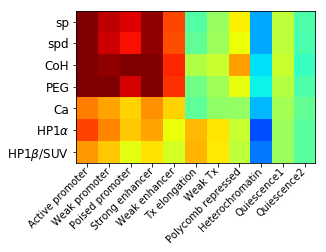

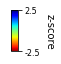

In [21]:
### plot heatmap for mean z-scores by chromHMM and condensing agents
img = []
for dkey in dkey_list:
    print dkey
    row = []
    for state in states:
        mvalue = dkey_state_mvalue[dkey][state]
        row.append(mvalue)
    img.append(row)

# plot condensability heatmap
vmin = -2.5
vmax = 2.5
cmap = 'jet_r'

fig_width = 0.4*len(states)
fig_height = 0.4*len(dkey_list)

fig = plt.figure(figsize=(fig_width, fig_height))
im = plt.imshow(img,
                cmap=cmap,
                vmin=vmin,
                vmax=vmax)

plt.xticks(range(len(states)),
           states,
           ha='right',
           va='center',
           rotation_mode='anchor',
           rotation=45)
plt.yticks(range(len(dkey_list)),
           [agent_symbol[dkey[3]]  for dkey in dkey_list],
           fontsize=12)
plt.savefig("./data/" + "H1_agent_ChromHMM_zscore.svg",
            format='svg',
            bbox_inches='tight')
plt.show()
plt.close()

# plot colorbar only
fig = plt.figure(figsize=(1.2,1))
plt.subplot(1,2,1)
cbar = plt.colorbar(im,
                    cax=plt.gca(),
                    ticks=[vmin, vmax])
cbar.ax.set_yticklabels([vmin, vmax], fontsize=8)
cbar.ax.set_ylabel('z-score',
                   rotation=-90,
                   va="bottom",
                   fontsize=10)
plt.tight_layout()
plt.savefig("./data/" + "H1_agent_ChroHMM_cbar.svg",
            format='svg',
            bbox_inches='tight')
plt.show()
plt.close()